In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

In [43]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = all_df[all_df['Cell type','Meta'] == 'Basal']
basals = basals[~basals['Border','Meta'].astype(bool)]

births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))


In [49]:


reducer = umap.UMAP()
all_meas = basals.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
basals['Umap1','Umap'] = embedding[:,0]
basals['Umap2','Umap'] = embedding[:,1]

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_63097/2898928999.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  basals['Umap1','Umap'] = embedding[:,0]
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_63097/2898928999.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  basals['Umap2','Umap'] = embedding[:,1]


<Axes: xlabel='Umap1', ylabel='Umap2'>

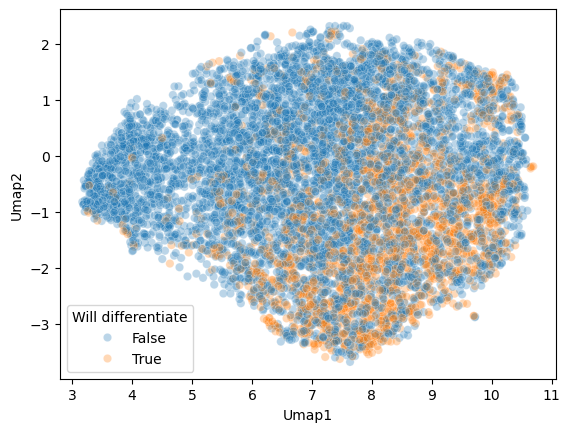

In [4]:
sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Will differentiate',alpha=0.3)

<Axes: xlabel='Umap1', ylabel='Umap2'>

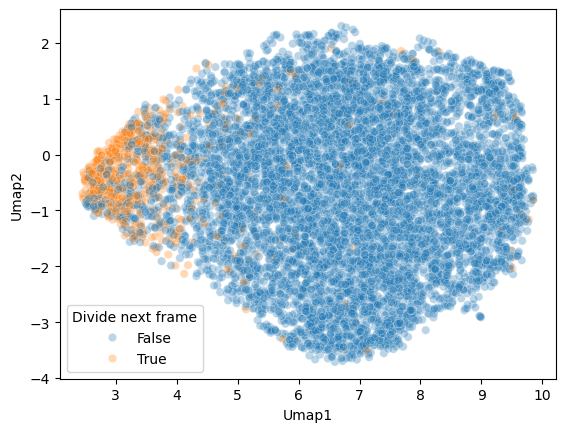

In [63]:
sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Divide next frame',alpha=0.3)

<Axes: xlabel='Umap1', ylabel='Umap2'>

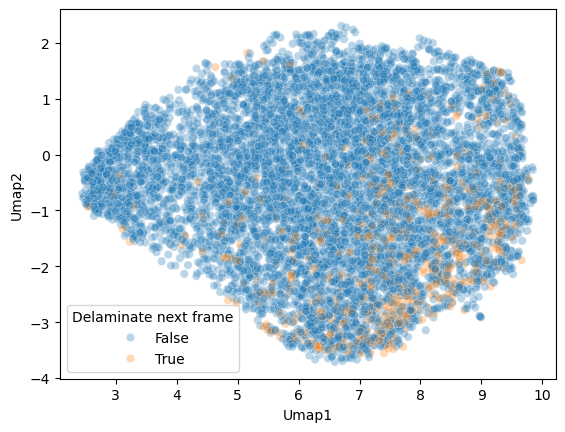

In [65]:
sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Delaminate next frame',alpha=0.3)

<Axes: xlabel='Umap1', ylabel='Umap2'>

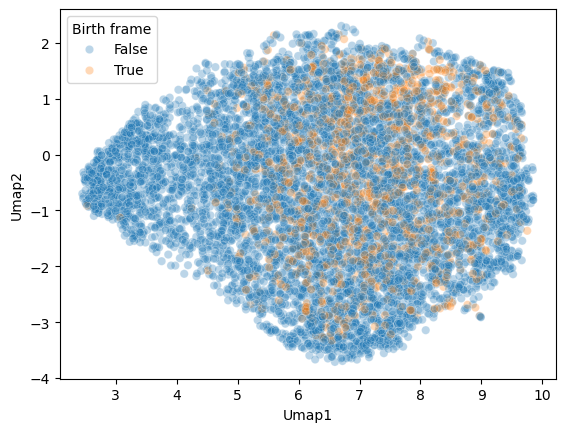

In [67]:
sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Birth frame',alpha=0.3)

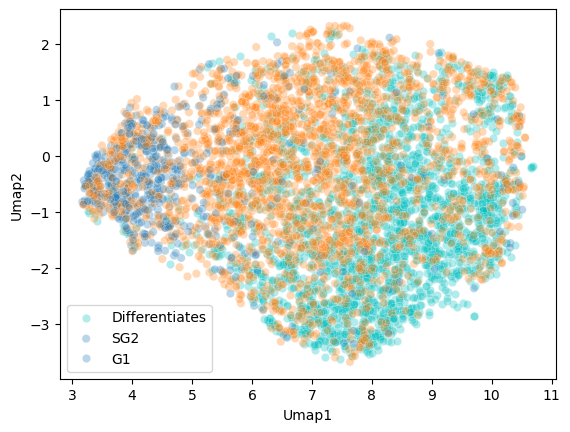

In [27]:
fig, ax = plt.subplots()

sb.scatterplot(basals[basals['Will differentiate','Meta']].droplevel(axis=1,level=1),
               x='Umap1',y='Umap2',alpha=0.3, ax=ax, color='c')
sb.scatterplot(basals[basals['Will divide','Meta'] &
    (basals['Cell cycle phase','Meta'] != 'NA')].droplevel(
    axis=1,level=1),x='Umap1',y='Umap2',hue='Cell cycle phase',alpha=0.3, ax=ax)
plt.legend(['Differentiates','SG2','G1'])


<Axes: xlabel='Umap1', ylabel='Umap2'>

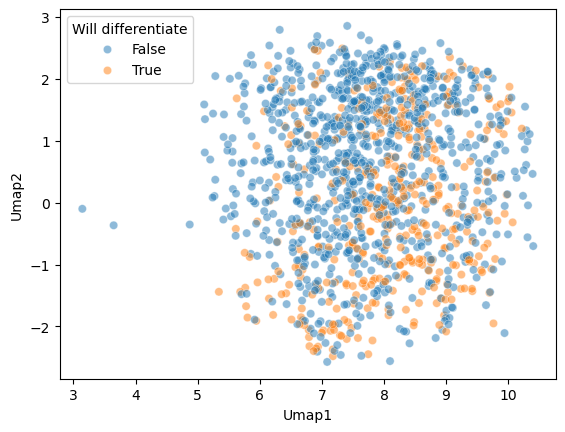

In [58]:
fig, ax = plt.subplots()

_df = basals[basals['Birth frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2',alpha=0.5, ax=ax, hue='Will differentiate')

<Axes: xlabel='Umap1', ylabel='Umap2'>

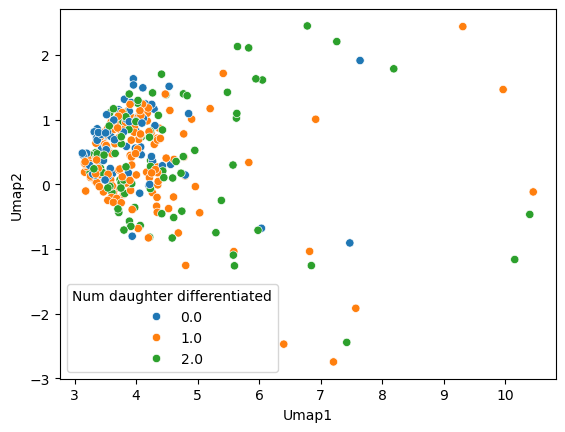

In [67]:
fig, ax = plt.subplots()

_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=1, ax=ax, hue='Num daughter differentiated')


<Axes: xlabel='Umap1', ylabel='Umap2'>

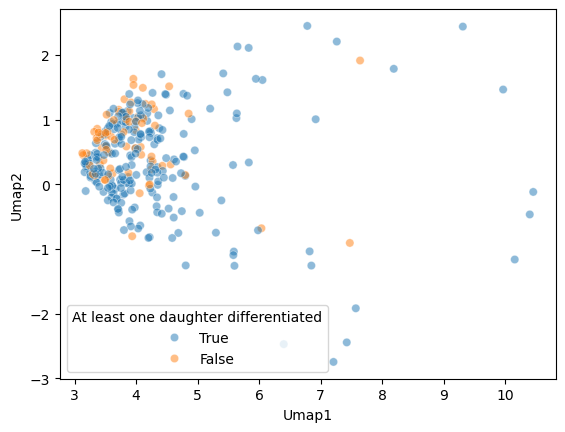

In [69]:
fig, ax = plt.subplots()

_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=0.5, ax=ax, hue='At least one daughter differentiated')


## Isolated frames -> then UMAP

This seems unstable

In [44]:
births = births[~births['Border','Meta'].astype(bool)]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]

<Axes: xlabel='Umap1', ylabel='Umap2'>

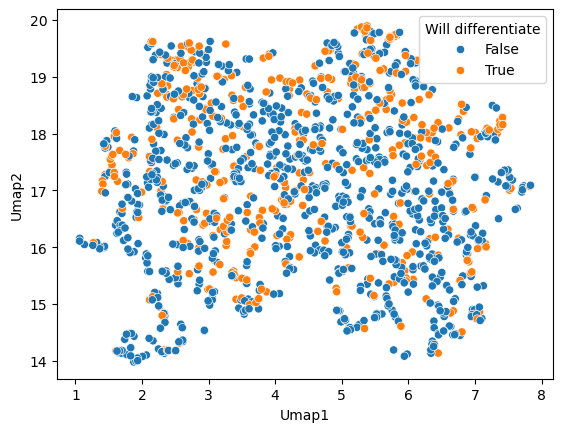

In [47]:
reducer = umap.UMAP()
all_meas = births.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
births['Umap1','Umap'] = embedding[:,0]
births['Umap2','Umap'] = embedding[:,1]

fig, ax = plt.subplots()

sb.scatterplot(births.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Will differentiate')


In [41]:
reducer = umap.UMAP()
all_meas = divisions.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
divisions['Umap1','Umap'] = embedding[:,0]
divisions['Umap2','Umap'] = embedding[:,1]
fig, ax = plt.subplots()

sb.scatterplot(divisions.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Num daughter differentiated')


<Axes: xlabel='Umap1', ylabel='Umap2'>

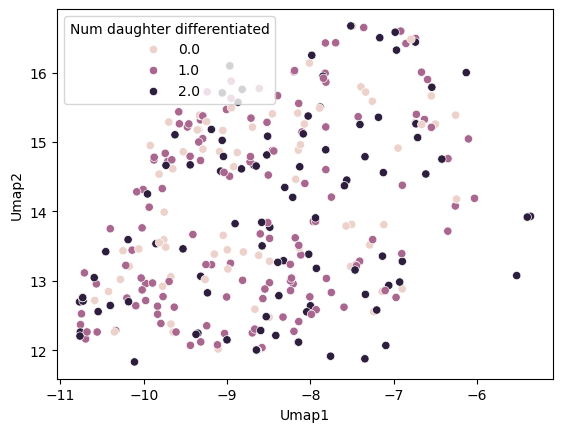